In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('sales_history_generated.csv')
ts = df[df['sku'] == 'product_a'].set_index('date').quantity
ts.index = pd.to_datetime(ts.index)
ts = ts.resample('W').sum()

n_train = int(0.8 * len(ts)) # 80% of the data as training set
ts_train, ts_test = ts[:n_train], ts[n_train:]

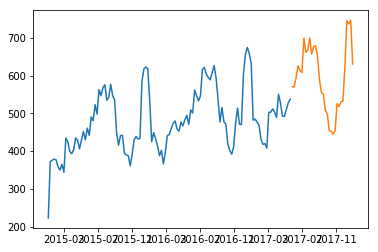

In [3]:
plt.plot(ts_train.index, ts_train.values, ts_test.index, ts_test.values)

In [192]:
class Forecasting(object):
    """
    Class that contains all forecasting methods to perform best forecast model selection.
    """
    
    def __init__(self, dataframe, skuId):
        """
        Dataframe should have one column called 'sku' and another called 'date'.
        We then use the skuId to select which SKU we want to perform forecasting on.
        """
        self.dataset = dataframe
        self.skuId = skuId
        
    # Functions used in the forecasting methods/to compare them
    
    def create_dataset(self, period, ratio=0.8):
        """
        Create training and testing dataframes given a given ratio of training examples. 
        The period can be weeks ('W'), months ('M') or any other Pandas-allowed resampling period.
        """
        df = self.dataset
        ts = df[ df['sku'] == self.skuId ].set_index('date').quantity
        ts.index = pd.to_datetime(ts.index)
        ts = ts.resample(period).sum()
        
        self.n_train = int(ratio * len(ts))
        self.n_test = len(ts) - self.n_train
        self.ts_train, self.ts_test = ts[:self.n_train], ts[self.n_train:]
        
    def _mean_squared_error(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        return np.sum((y_true - y_pred)**2)
    
    def _detect_peaks(self, ts):
        """
        Detect all the peaks of a time series. 
        A peak occurs when the slope has different signs of each side of a point.
        """
        peak_idx = []
        for i in range(1, len(ts)-1):
            compare_left = ts[i] - ts[i-1]
            compare_right = ts[i+1] - ts[i]
            if np.sign(compare_left) != np.sign(compare_right):
                peak_idx.append(i)
        return peak_idx
    
    def _periodicity_check(self, ts):
        """
        By looking at where a time series has strongest autocorrelation, we can identify its period.
        In the case of no particular autocorrelation, the period will be set as a year (12 for 'M' or 52 for 'W').
        """
        y = sm.tsa.seasonal_decompose(ts)
        autocorr = sm.tsa.stattools.acf(y.seasonal, nlags=len(y.seasonal))
        peak_idx = self._detect_peaks(autocorr)
        max_idx = np.argmax(autocorr[peak_idx]) # find index of the highest peak
        return peak_idx[max_idx]
    
    # Forecasting methods
    
    def moving_average(self, sliding_window=7):
        """
        Moving average forecasting. Future predictions are constant and equal to last predicted value.
    
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        sliding_window: Quantity of past obversations used in moving average calculation
        """
        ts = self.ts_train
        dates = self.ts_test.index
        
        y_pred = ts.rolling(sliding_window).mean().iloc[-1]
    
        return pd.Series(y_pred, index=dates)
    
    def simple_exp_smoothing(self):
        """
        Simple exponential smoothing forecasting. Future predictions are constant and equal to last predicted value.
    
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        """
        ts = self.ts_train
        dates = self.ts_test.index
        
        y_pred = sm.tsa.SimpleExpSmoothing(ts)
        y_pred.fit(optimized=True)
        y_hat = y_pred.predict(y_pred.params, start=dates[0], end=dates[-1])
    
        return pd.Series(y_hat, index=dates)
    
    def linear_regression(self):
        """
        Linear regression forecasting (with unit time steps).
        
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        """
        ts = self.ts_train
        dates = self.ts_test.index
        
        X = sm.add_constant(np.array(range(self.n_train)))
        y = np.reshape(ts.values, (-1, 1))
        
        y_pred = sm.OLS(y, X)
        y_fit = y_pred.fit()

        t_hat = sm.add_constant(self.n_train + np.array(range(self.n_test)))
        y_hat = y_fit.predict(t_hat)
        
        return pd.Series(y_hat, index=dates)
    
    def Holt_linear(self):
        """
        Holt's linear tread forecasts.
    
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        """
        ts = self.ts_train
        dates = self.ts_test.index
        
        y_pred = sm.tsa.Holt(ts, exponential=False)
        y_pred.fit(optimized=True)
        y_hat = y_pred.predict(y_pred.params, start=dates[0], end=dates[-1])
    
        return pd.Series(y_hat, index=dates)
    
    def HoltWinters_additive(self):
        """
        Holt-Winters forecasting. 
        We need to pre-analyze the data to detect the presence or absence of seasonality.
    
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        """
        ts = self.ts_train
        dates = self.ts_test.index
    
        seasonal_periods = self._periodicity_check(ts)
    
        y_pred = sm.tsa.ExponentialSmoothing(self.ts_train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        y_pred.fit(optimized=True)
        y_hat = y_pred.predict(y_pred.params, start=dates[0], end=dates[-1])
    
        return pd.Series(y_hat, index=dates)
    
    def ARIMA(self, P=3, D=2, Q=2):
        """
        ARIMA forecasting models, no seasonality.
     
        ts: Training time series upon which we base the forecast
        dates: Range of dates used for forecasting predictions 
        """
        ts = self.ts_train.astype('float32')
        dates = self.ts_test.index
        ts_test = self.ts_test.astype('float32')

        all_models = {}
    
        for p in range(P):
            for d in range(D):
                for q in range(Q):
                
                    order = (p, d, q)
                
                    y = sm.tsa.ARIMA(ts, order)
                    y_fit = y.fit()
                    y_hat = y.predict(y_fit.params, start=dates[0], end=dates[-1])
                
                    RMSE = np.sqrt(self._mean_squared_error(ts_test.values, y_hat))
                    all_models[order] = (RMSE, pd.Series(y_hat, index=dates)) 
                
        best_models = sorted(all_models, key=all_models.get)[:3] # three best models
    
        models = {}
        for bm in best_models:
            models[bm] = all_models[bm]
    
        return models
    
    def compare_models(self, period, sliding_window=7, P=3, D=2, Q=2):
        """
        Compute RMSE for all forecasting models and choose the one with the lowest value on test set.
        """
        RMSE = {}
        
        self.create_dataset(period=period)
        
        self.moving_average_forecast = self.moving_average(sliding_window=sliding_window)
        RMSE['moving_average'] = np.sqrt(self._mean_squared_error(self.ts_test.values, self.moving_average_forecast.values))
        
        self.simple_exp_smoothing_forecast = self.simple_exp_smoothing()
        RMSE['simple_exp_smoothing'] = np.sqrt(self._mean_squared_error(self.ts_test.values, self.simple_exp_smoothing_forecast.values))
        
        self.linear_regression_forecast = self.linear_regression()
        RMSE['linear_regression'] = np.sqrt(self._mean_squared_error(self.ts_test.values, self.linear_regression_forecast.values))
        
        self.Holt_linear_forecast = self.Holt_linear()
        RMSE['Holt_linear'] = np.sqrt(self._mean_squared_error(self.ts_test.values, self.Holt_linear_forecast.values))
        
        self.HoltWinters_additive_forecast = self.HoltWinters_additive()
        RMSE['HoltWinters_additive'] = np.sqrt(self._mean_squared_error(self.ts_test.values, self.HoltWinters_additive_forecast.values))
        
        self.ARIMA_forecast_models = self.ARIMA(P=P, D=D, Q=Q)
        for model in self.ARIMA_forecast_models:
            RMSE['ARIMA (p, d, q) = ' + str(model)] = self.ARIMA_forecast_models[model][0]
        
        # comparison based on RMSE
        sorted_models = sorted(RMSE.keys(), key=(lambda key: RMSE[key]))
        best_model = sorted_models[0]
        print('The best model is ' + str(best_model) + ', with an RMSE of ' + str(RMSE[best_model]))
        
        self.RMSE = RMSE

In [193]:
fc = Forecasting(df, 'product_a')

fc.compare_models(period='W')

The best model is HoltWinters_additive, with an RMSE of 157.33644778984424


In [194]:
fc.RMSE

{'ARIMA (p, d, q) = (1, 0, 0)': 792.1841794810606,
 'ARIMA (p, d, q) = (1, 0, 1)': 805.0741740980308,
 'ARIMA (p, d, q) = (2, 0, 0)': 809.2517890523503,
 'HoltWinters_additive': 157.33644778984424,
 'Holt_linear': 533.5933530960245,
 'linear_regression': 557.893883099637,
 'moving_average': 655.6309937762247,
 'simple_exp_smoothing': 593.7979454326194}